###  Import libraries


In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

### Hiperparámetros

In [2]:
csv_path          = "jena_climate_2009_2016.csv"
predicted_feature = 0 #T (degC)

train_perc = .7
val_perc   = .2

sequence_length = 24
offset          = 1
sampling_rate   = 6
batch_size      = 256

learning_rate   = 0.001
epochs          = 10
loss            = "mse"

### Read CSV

In [3]:
data = pd.read_csv(csv_path, parse_dates=True, index_col=0)

In [4]:
df = data.drop(['Tpot (K)', 'p (mbar)','wv (m/s)', 'max. wv (m/s)', 'wd (deg)'],axis = 1)
#df = data.drop(["Tpot (K)",
#                "Tdew (degC)",
#                "rh (%)",
#                "VPact (mbar)",
#                "H2OC (mmol/mol)",
#                "max. wv (m/s)",
#                "wd (deg)",],axis = 1)
df.head()

,T (degC),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3)
Date Time,,,,,,,,,
2009-01-01 00:10:00,-8.02,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75
2009-01-01 00:20:00,-8.41,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80
2009-01-01 00:30:00,-8.51,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24
2009-01-01 00:40:00,-8.31,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19
2009-01-01 00:50:00,-8.27,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00


### Step 7: Add periodic time intervals

In [5]:
timestamp_s = df.index
timestamp_s = timestamp_s.map(pd.Timestamp.timestamp)

In [6]:
day = 24*60*60
year = 365.2425 * day

In [7]:
df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

### Step 8: Splitting data

In [8]:
df_length = len(df)

train_length = int(df_length*train_perc)
val_length   = int(df_length*(train_perc+val_perc))

train_mean = df.values[:train_length].mean()
train_std  = df.values[:train_length].std()

df_norm = (df.values - train_mean) / train_std
df_norm = pd.DataFrame(df_norm)

### Step 9: Normalize data
- Only normalize data based on training data
    - Notice you should only normalize the training data - because validation and test data could affect the normalization
- Get the mean and standard deviation of the data
    - HINT: Use **.mean()** and **.std()** on the dataframe.
- Noramlize the data as follows
    - **train_df = (train_df - train_mean) / train_std** (assuming naming fits)
    - HINT: The transformation of validation and test data is done similarly with **train_mean** and **train_std**.

In [9]:
train_df = df_norm[:train_length-1]
val_df   = df_norm[train_length:val_length-1]
test_df_norm  = df_norm[val_length:]
test_df       = df[val_length:]

### Step 10: Create datasets


In [10]:
start = sequence_length*sampling_rate + offset*sampling_rate
end   = train_length + start

x_train = train_df
y_train = df_norm[[predicted_feature]][start:end]

dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train.values,
    y_train,
    sequence_length = sequence_length,
    sampling_rate = sampling_rate,
    shuffle=True,
    batch_size = batch_size
)

In [11]:
start = train_length + sequence_length*sampling_rate + offset*sampling_rate
end   = val_length + start

x_val = val_df
y_val = df_norm[[predicted_feature]][start:end]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val.values,
    y_val,
    sequence_length = sequence_length,
    sampling_rate = sampling_rate,
    shuffle=False,
    batch_size = batch_size
)

In [12]:
start = val_length + sequence_length*sampling_rate + offset*sampling_rate
x_end = len(test_df_norm) - sequence_length*sampling_rate - offset*sampling_rate

x_test = test_df_norm[:x_end]
y_test = df_norm[[predicted_feature]][start:]

dataset_test = keras.preprocessing.timeseries_dataset_from_array(
    x_test.values,
    y_test,
    sequence_length = sequence_length,
    sampling_rate = sampling_rate,
    shuffle=False,
    batch_size = batch_size
)

In [13]:
def create_dataset(df, input_width=24, offset=0, predict_column=0):
    x = []
    y = []
    data_x = df.to_numpy()
    data_y = df[predict_column].to_numpy()
    
    for i in range(input_width, len(data_x) - offset):
        x.append(data_x[i - input_width:i,:])
        y.append(data_y[i + offset])
        
    x = np.array(x)
    y = np.array(y)
    
    return x, y.reshape(-1,1)

In [14]:
test_df_norm = test_df_norm[5::6]
x_norm, y_norm = create_dataset(test_df_norm, input_width = sequence_length, predict_column = predicted_feature)

test_df = test_df[5::6]
x_real, y_real = create_dataset(pd.DataFrame(test_df.values), input_width = sequence_length, predict_column = predicted_feature)

### Step 11: Create model
- Create the following model
    - **model = models.Sequential()**
    - **model.add(layers.LSTM(32, return_sequences=True, input_shape=train_ds[0].shape[1:]))**
    - **model.add(layers.Dense(units=1))**

In [15]:
for batch in dataset_train.take(1):
    x, y = batch
    
input_shape = x.shape[1], x.shape[2]

In [16]:
inputs = keras.layers.Input(input_shape)
#lstm_layer = keras.layers.LSTM(32, return_sequences=True)(inputs)
lstm_layer2 = keras.layers.LSTM(32)(inputs)
output = keras.layers.Dense(1)(lstm_layer2)

model = keras.Model(inputs, output)
model.compile(keras.optimizers.Adam(learning_rate), loss)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 24, 13)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                5888      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 5,921
Trainable params: 5,921
Non-trainable params: 0
_________________________________________________________________


### Step 12: Train model
- Compile and fit the model
- Complie the model as follows
    - **model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])**
- Fit the model as follows
    - **model.fit(x=train_ds[0], y=train_ds[1], validation_data=(val_ds[0], val_ds[1]), epochs=5)**

In [17]:
history = model.fit(dataset_train, epochs = epochs, validation_data=dataset_val)

Epoch 1/10
1150/1150 [==============================] - 20s 16ms/step - loss: 0.0018 - val_loss: 7.5873e-05
Epoch 2/10
1150/1150 [==============================] - 17s 15ms/step - loss: 5.9158e-05 - val_loss: 4.6763e-05
Epoch 3/10
1150/1150 [==============================] - 17s 15ms/step - loss: 3.8866e-05 - val_loss: 2.8333e-05
Epoch 4/10
1150/1150 [==============================] - 18s 15ms/step - loss: 3.0727e-05 - val_loss: 3.4810e-05
Epoch 5/10
1150/1150 [==============================] - 18s 16ms/step - loss: 2.8940e-05 - val_loss: 2.2035e-05
Epoch 6/10
1150/1150 [==============================] - 18s 15ms/step - loss: 2.6979e-05 - val_loss: 3.9093e-05
Epoch 7/10
1150/1150 [==============================] - 17s 15ms/step - loss: 2.5039e-05 - val_loss: 2.4160e-05
Epoch 8/10
1150/1150 [==============================] - 17s 15ms/step - loss: 2.3206e-05 - val_loss: 1.9333e-05
Epoch 9/10
1150/1150 [==============================] - 17s 15ms/step - loss: 2.1418e-05 - val_loss: 4.3397e

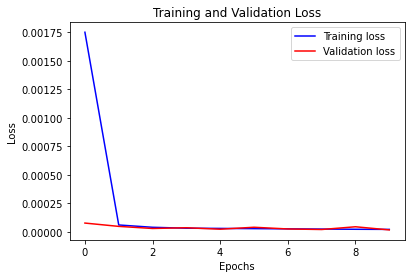

In [18]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

visualize_loss(history, "Training and Validation Loss")

### Step 13: Predict data
- Apply the model on the test data
    - HINT: Use **model.predict(x)**, where **x** is assigned to the test data.

In [19]:
y_pred = model.predict(x_norm)
y_pred = y_pred * train_std + train_mean

### Step 14: Plot the result
- Plot a window of the data predicted together with the actual data.
- One way:
    - **fig, ax = plt.subplots()**
    - **ax.plot(y[i:i+96*2,0], c='g')**
    - **ax.plot(pred[i:i+96*2,-1,0], c='r')**
- It will plot a window of 96 hours, where you can index with **i** (**i=150** as an example) and **y** is the real values and **pred** are the predicted values

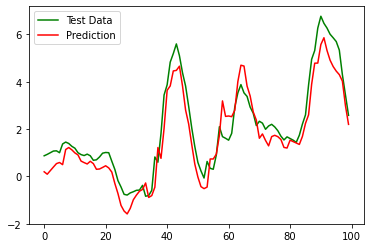

In [20]:
fig, ax = plt.subplots()

ax.plot(y_real[0:100], c='g', label="Test Data")
ax.plot(y_pred[0:100], c='r', label="Prediction")
plt.legend()

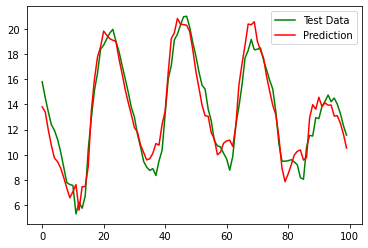

In [21]:
fig, ax = plt.subplots()

ax.plot(y_real[500:600], c='g', label="Test Data")
ax.plot(y_pred[500:600], c='r', label="Prediction")
plt.legend()

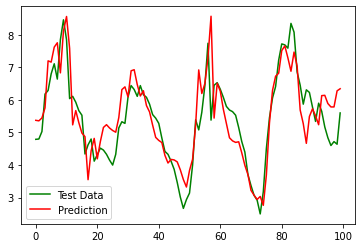

In [22]:
fig, ax = plt.subplots()

ax.plot(y_real[200:300], c='g', label="Test Data")
ax.plot(y_pred[200:300], c='r', label="Prediction")
plt.legend()

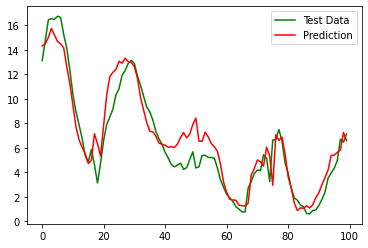

In [23]:
fig, ax = plt.subplots()

ax.plot(y_real[950:1050], c='g', label="Test Data")
ax.plot(y_pred[950:1050], c='r', label="Prediction")
plt.legend()

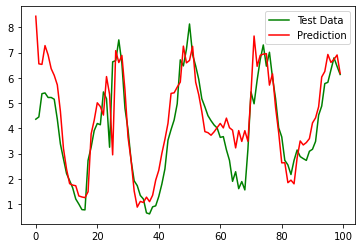

In [24]:
fig, ax = plt.subplots()

ax.plot(y_real[1000:1100], c='g', label="Test Data")
ax.plot(y_pred[1000:1100], c='r', label="Prediction")
plt.legend()

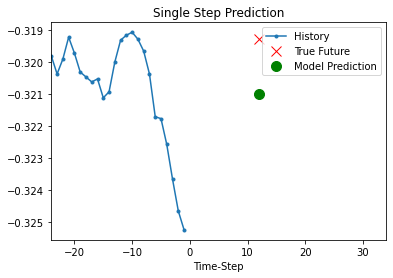

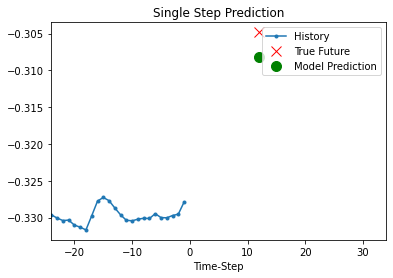

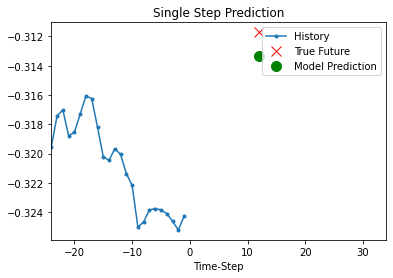

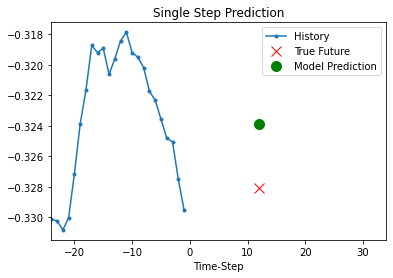

In [ ]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_test.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )